In [7]:
#!pip install facenet_pytorch

In [8]:
import os           

# Check if string is appropriate youtube link
import re
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import face_recognition

import seaborn as sns
import plotly.express as px

SAVE_VIDEO = True
SHOW_PROMPT = False

# DEBUG-Mode stops operations when max_emotions were detected and also prints a short summary
DEBUG = True
if DEBUG:
    import time
    debug_params = {
        'max_emotions' : 10000
    }

FRAMES_TO_SKIP = 1
MODEL_TYPE = "haarcascade"
NUM_THREADS = 4
THRESHOLD = 0.62
import tempfile
import requests
import torch

from PIL import Image
import torchvision.transforms as T
import torchreid
from sklearn.metrics.pairwise import cosine_similarity

import time
from concurrent.futures import ThreadPoolExecutor
from functools import partial

In [9]:


def extract_person_features(frame, model, transformer, face_location):
    x_min, x_max, y_min, y_max = face_location
    cropped_face = frame[y_min:y_max, x_min:x_max]
    
    # Check if the cropped_face is empty
    if cropped_face.size == 0:
        return None

    face_img = cv2.resize(cropped_face, (128, 256))
    face_img_pil = Image.fromarray(face_img)
    face_img_tensor = transformer(face_img_pil).unsqueeze(0)
    features = model(face_img_tensor).detach().numpy()
    return features.reshape(-1)




def build_transformer():
    return T.Compose([
        T.Resize((256, 128)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def find_matching_person(person_features, known_people_features, threshold=THRESHOLD):
    if len(known_people_features) == 0:
        return None

    similarities = cosine_similarity([person_features], known_people_features)[0]
    max_similarity = np.max(similarities)
    max_similarity_index = np.argmax(similarities)

    if max_similarity > threshold:
        return max_similarity_index
    else:
        return None
    
def get_path(kind):
    if kind == "youtube":
        #return "https://www.youtube.com/watch?v=vtT78TfDfXU"                   # Random video
        return 'https://www.youtube.com/watch?v=embYkODkzcs'                 # 7 basic emotions
        #return 'https://www.youtube.com/watch?v=m70UInZKJjU'                    # Two persons
        #return 'https://www.youtube.com/watch?v=QRnw9f5rbN4'
    if kind == "local":
        # adjust individually
        return '/Users/steve/Neue_Fische/face_demo/vids/Video_One_output.mp4'
    if kind == "error_on_purpose":
        return "wrongful path"
    else:
        raise ValueError(f"Passed Argument kind must bei in ['youtube', 'local', 'error_on_purpose'] but was: {kind}")

def youtube_stream(yt_link):
    # Load the video from YouTube
    yt_video = YouTube(yt_link)
    stream = yt_video.streams.get_highest_resolution()  # get the highest resolution stream
    print("Title:", yt_video.title)
    print("Length:", yt_video.length, "seconds")
    print("Available video quality options:")
    resolutions = set()  # use a set to keep track of unique resolutions
    
    with tempfile.NamedTemporaryFile(suffix='.mp4') as f:
        response = requests.get(stream.url)
        f.write(response.content)

        # Open the video stream in OpenCV
        video = cv2.VideoCapture(f.name)

    return video

    

def local_stream(local_path):
    return cv2.VideoCapture(local_path)

def get_stream(path):
    # Check if the string is a YouTube link
    if re.match(r'(https?://)?(www\.)?(youtube\.com|youtu\.?be)/.+$', path):
        return youtube_stream(path)
    # Check if the string is a local path
    elif os.path.isfile(path):
        return local_stream(path)
    # Check if the path is a local file path but no file is found
    elif os.path.exists(path):
        raise ValueError(f"File not found at path: {path}")
    # If it's neither a local path nor a YouTube link, raise an error
    else:
        raise ValueError("The input string is neither a local path nor a YouTube link.")
    
def load_emotion_classifier():
    return load_model("../models/emotion_model.hdf5", compile=False)

def preprocess_face(face, input_face_size):
    face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)  # Convert the face to grayscale
    face = cv2.resize(face, (input_face_size[1], input_face_size[0]))  # Swap width and height
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=-1)  # Add an additional dimension for grayscale channel
    face = np.expand_dims(face, axis=0)
    return face


def print_debug_report(emotions, frame_info, processing_time):
    print("Emotions detected:")
    for emotion, probability in emotions:
        print(f"{emotion}: {probability:.1%}")

    print("\nFrame info:")
    for pos_sec, frame_nr in frame_info:
        print(f"Second {pos_sec}, Frame {frame_nr}")

    print(f"\nProcessing time: {processing_time:.2f} seconds")

def initialize_face_detector(model_type):
    if model_type == 'haarcascade':
        return cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    elif model_type == "MTCNN":
        return MTCNN(keep_all=True, post_process=False, margin=20)
    else:
        raise ValueError("By now, only Haarcascade is implemented.")

def preprocess_frame_for_face_detection_haarcascade(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

def preprocess_frame_for_emotion_detection(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def normalize_boxes_mtcnn(boxes):
    """
    Normalize the bounding box coordinates from MTCNN to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        normalized_boxes.append([y_min, y_max, x_min, x_max])
    return np.array(normalized_boxes)

def normalize_boxes_cv2(boxes):
    """
    Normalize the bounding box coordinates from OpenCV's format to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x, y, w, h = box
        normalized_boxes.append([y, y+h, x, x+w])
    return np.array(normalized_boxes)

def detect_faces(frame, face_detector, model_type = 'haarcascade'):
    if model_type == 'haarcascade':
        frame_pp = preprocess_frame_for_face_detection_haarcascade(frame)
        boxes =  face_detector.detectMultiScale(frame_pp, scaleFactor = 1.3, minNeighbors = 3)
        if boxes is None:
            return None
        else:
            return normalize_boxes_cv2(boxes)
    elif model_type == "MTCNN":
        # No preprocessing needed for VideoCapture Frame
        boxes, _ = face_detector.detect(frame)
        if boxes is None:
            return None
        else:
            return normalize_boxes_mtcnn(boxes)
        #return [(x['box'][1], x['box'][0] + x['box'][2], x['box'][1] + x['box'][3], x['box'][0]) for x in bounding_boxes]
    #elif model_type == "fast_MTCNN"
    # https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
    else:
        raise ValueError("By now, only Haarcascade is implemented.")
    
def get_ordered_emotions():
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def emotions_probability(frame, face_location, emotion_classifier):
    frame_pp = preprocess_frame_for_emotion_detection(frame)
    y_min, y_max, x_min, x_max = face_location
    face = frame_pp[y_min:y_max, x_min:x_max]
    face = preprocess_face(face, input_face_size=emotion_classifier.input_shape[1:3])
    prob = emotion_classifier.predict(face)[0]  # check for underscore
    return prob

def output_video(video, filename):
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    return cv2.VideoWriter(filename, fourcc, 10, (width,height))

def get_overview_df(emotions, frame_info, frame_info_cols):
    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    return df_all_info

def get_plottable_df(emotions, frame_info, frame_info_cols, ):

    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    df_plotting = pd.melt(df_all_info, id_vars=frame_info_cols, value_vars=get_ordered_emotions(), var_name='emotion', value_name='probability')
    return df_plotting

def get_user_config():
    path = get_path('youtube')
    frames_to_skip = 8
    output_filename = 'outputs/Output_video.mp4'
    return path, frames_to_skip, output_filename

In [10]:
# Load the pre-trained person re-identification model
model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=0,
    loss='softmax',
    pretrained=True
)

# Set the model to evaluation mode
model.eval()

# Load the weights of the pre-trained model
torchreid.utils.load_pretrained_weights(model, 'osnet_x1_0_imagenet.pth')

# Build a transformer for the model
transformer = build_transformer()

Successfully loaded imagenet pretrained weights from "/Users/steve/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Successfully loaded pretrained weights from "osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [15]:
def process_frame(frame, frame_nr, face_detector, emotion_classifier, known_people_features, video):
    face_locations = detect_faces(frame, face_detector, MODEL_TYPE)

    if face_locations is None:
        return frame, [], []

    emotions_in_frame = []
    frame_data = []

    for i, face_location in enumerate(face_locations):
        person_features = extract_person_features(frame, model, transformer, face_location)

        if person_features is None:
            continue

        person_id = find_matching_person(person_features, known_people_features)

        if person_id is None:
            person_id = len(known_people_features) + 1
            known_people_features.append(person_features)

        prob = emotions_probability(frame, face_location, emotion_classifier)
        max_emotion, max_prob = np.argmax(prob), np.max(prob)
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        emotion_text = emotion_labels[max_emotion]

        (y_min, y_max, x_min, x_max) = face_location
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(frame, f"Prob: {max_prob:.1%}", (x_min, y_max + 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        cv2.putText(frame, f"{emotion_text}", (x_min, y_max + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        cv2.putText(frame, f"Person: {person_id}", (x_min, y_min - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        emotions_in_frame.append((emotion_text, max_prob))
        frame_data.append((round(video.get(cv2.CAP_PROP_POS_MSEC) / 1000, 2), frame_nr))

    return frame, emotions_in_frame, frame_data



def main():
    global DEBUG, SAVE_VIDEO
    
    if DEBUG:
        start_time = time.time()
    
    path, frames_to_skip, output_filename = get_user_config()
    
    video = get_stream(path)
    
    if SAVE_VIDEO:
        writer = output_video(video, filename=output_filename)

    face_detector = initialize_face_detector(MODEL_TYPE)
    emotion_classifier = load_emotion_classifier()

    known_people_features = []
    emotions = []
    frame_info = []
    frames = []
    current_frame_nr = 0
    
    while True:
        ret, frame = video.read()
        
        if not ret:
            break

        current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

        if current_frame_nr % frames_to_skip != 0:
            continue

        processed_frame, emotions_in_frame, frame_data = process_frame(frame, current_frame_nr, face_detector, emotion_classifier, known_people_features, video)

        if emotions_in_frame:
            emotions.extend(emotions_in_frame)
            frame_info.extend(frame_data)
        
        
        if emotions:
            emotions.extend(emotions_in_frame)
            frame_info.extend(frame_data)
        
        if DEBUG:
            if len(emotions) > debug_params['max_emotions']:
                break
        
        cv2.imshow("Faces found", processed_frame)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    video.release()

    if SAVE_VIDEO:
        writer.release()

    cv2.destroyAllWindows()
    '''
    if DEBUG:
        end_time = time.time()
        print_debug_report(emotions, frame_info, end_time - start_time)
    '''
    df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

if __name__ == "__main__":
    main()





Title: The 7 basic emotions - Do you recognise all facial expressions?
Length: 115 seconds
Available video quality options:


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 [==============================] - 0s 243ms/step


2023-03-22 14:34:08.929159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


KeyboardInterrupt: 

: 

In [ ]:
frame, emotions_in_frame, frame_data = process_frame(frame, frame_nr, face_detector, emotion_classifier, known_people_features, video)

NameError: name 'frame' is not defined

In [ ]:
if __name__ == "__main__":
    main()

Title: The 7 basic emotions - Do you recognise all facial expressions?
Length: 115 seconds
Available video quality options:


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
2023-03-22 11:49:11.276613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 11:49:11.276996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
# Load the pre-trained person re-identification model
model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=0,
    loss='softmax',
    pretrained=True
)

# Set the model to evaluation mode
model.eval()

# Load the weights of the pre-trained model
torchreid.utils.load_pretrained_weights(model, 'osnet_x1_0_imagenet.pth')

# Build a transformer for the model
transformer = build_transformer()






if DEBUG: start_time = time.time()

# Define video path
path = get_path('youtube')

# Set the number of frames to skip
frames_to_skip = 8

# Get Video as cv2.VideoCapture
# Can access Youtube Video or local file
video = get_stream(path)

# Initialize writer to save the annotated video
if SAVE_VIDEO: writer = output_video(video, filename='outputs/Output_video.mp4')

# Initialize the face detection model
#model_type = "MTCNN"
model_type = "haarcascade"
face_detector = initialize_face_detector(model_type)


# Initialize the emotion detection model
emotion_classifier = load_emotion_classifier()

# Initialize lists to store emotions and frame_info
emotions = []
frame_info = []

# Initialize counters
frames_without_faces_counter = 0
individual_id_counter = 0
face_embeddings = {}


# Initialize an empty dictionary to store detected person features and IDs
detected_persons = {}
known_people_features = []

# Keep track of the last assigned person ID
last_person_id = 0



Title: The 7 basic emotions - Do you recognise all facial expressions?
Length: 115 seconds
Available video quality options:


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
2023-03-22 10:56:25.045867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 10:56:25.046242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [ ]:
# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame counter
    current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Skip frames based on the frames_to_skip parameter
    if current_frame_nr % frames_to_skip != 0:
        continue
    
    # Find faces within a frame and return list of coordinates of bounding boxes
    face_locations = detect_faces(frame, face_detector, model_type)

    # Check if any faces were found
    if face_locations is None:
        frames_without_faces_counter += 1
        continue

    
      
    for i, face_location in enumerate(face_locations):
        # Extract the person's features
        person_features = extract_person_features(frame, model, transformer, face_location)
        # If person_features is None, continue to the next iteration
        if person_features is None:
            continue
        # Check if the person matches any known person
        person_id = find_matching_person(person_features, known_people_features)
         # If the person is not recognized, add their features to the list of known people
        if person_id is None:
            person_id = len(known_people_features) + 1
            known_people_features.append(person_features)
        # Emotion detection
        prob = emotions_probability(frame, face_location, emotion_classifier)
        emotions.append(prob)
        
        frame_info.append(
            (round(video.get(cv2.CAP_PROP_POS_MSEC) / 1000, 2),
                current_frame_nr
                )
        )    
        max_emotion, max_prob = np.argmax(prob), np.max(prob)
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        emotion_text = emotion_labels[max_emotion]

        (y_min, y_max, x_min, x_max) = face_location
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(frame, f"Prob: {max_prob:.1%}", (x_min, y_max + 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        cv2.putText(frame, f"{emotion_text}", (x_min, y_max + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        cv2.putText(frame, f"Person: {person_id}", (x_min, y_min - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    cv2.imshow("Faces found", frame)

        # Wait for Esc key to stop
    k = cv2.waitKey(30) & 0xff
    if k == 27:
            break

    if DEBUG:
        # For debugging reasons, we stop when we have 1000 emotion values
        if len(emotions) > debug_params['max_emotions']:
            break

# Release the video and close the window
video.release()

if SAVE_VIDEO: writer.release()

# De-allocate any associated memory usage
cv2.destroyAllWindows()

if DEBUG: end_time = time.time()

if DEBUG:
    # When in DEBUG-mode, print some statistics about the faces and emotions detected
    operating_results = {'analyzed_emotions': len(emotions),
                         'analyzed_frames':frame_info[-1][1], 
                         'frames_without_faces':frames_without_faces_counter,
                         'frames_without_faces_ratio': round(100*frames_without_faces_counter/frame_info[-1][1],2),
                         'processed_video_time': round(frame_info[-1][0] / 1000 ,2),
                         'runtime': round(end_time - start_time,2)}
    
    print_debug_report(operating_results)
    
df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

2023-03-22 10:56:27.438531: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-22 10:56:27.628303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

In [ ]:
df_plotting

,pos_sec,frame,emotion,probability
0,6.36,160,Angry,0.018778
1,6.68,168,Angry,0.032896
2,7.00,176,Angry,0.073128
3,7.32,184,Angry,0.047606
4,7.32,184,Angry,0.032855
...,...,...,...,...
646,93.08,2328,Neutral,0.195752
647,93.40,2336,Neutral,0.358018
648,93.72,2344,Neutral,0.512138
649,94.04,2352,Neutral,0.473076


In [ ]:
"""
        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
    for i, face_landmark in enumerate(face_landmarks):
        if not face_landmark:
            continue

        if i < len(face_locations):
            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]
        else:
            continue            
        current_individual_ids = []

        # Compare the current face encoding with the existing face embeddings
        for individual_id, individual_face_encoding in face_embeddings.items():
            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:
                current_individual_ids.append(individual_id)
                break
        else:
            individual_id_counter += 1
            current_individual_ids.append(individual_id_counter)
            face_embeddings[individual_id_counter] = face_encoding
    """

'\n        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]\n    for i, face_landmark in enumerate(face_landmarks):\n        if not face_landmark:\n            continue\n\n        if i < len(face_locations):\n            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]\n        else:\n            continue            \n        current_individual_ids = []\n\n        # Compare the current face encoding with the existing face embeddings\n        for individual_id, individual_face_encoding in face_embeddings.items():\n            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:\n                current_individual_ids.append(individual_id)\n                break\n        else:\n            individual_id_counter += 1\n            current_individual_ids.append(individual_id_counter)\n            face_embeddings[individual_id_counter] = face_encoding\n    '

In [ ]:
df_overview  = get_overview_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

In [ ]:
df_overview.head(30)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame
0,0.018778,0.003345,0.039960,0.003450,0.374159,0.111742,0.448565,6.36,160
1,0.032896,0.000055,0.493439,0.000659,0.127527,0.264904,0.080519,6.68,168
2,0.073128,0.000128,0.169718,0.010384,0.150450,0.082508,0.513685,7.00,176
3,0.047606,0.000112,0.224378,0.004717,0.230398,0.052003,0.440787,7.32,184
4,0.032855,0.005101,0.083288,0.663063,0.056687,0.020283,0.138723,7.32,184
5,0.040339,0.000191,0.342667,0.004715,0.192386,0.059851,0.359850,7.64,192
6,0.033385,0.000181,0.178444,0.006105,0.160254,0.063582,0.558050,7.96,200
7,0.050084,0.000148,0.227702,0.007377,0.193296,0.068762,0.452632,8.28,208
8,0.057740,0.000318,0.229091,0.007289,0.185727,0.018300,0.501536,8.60,216
9,0.035875,0.000187,0.186242,0.004120,0.159717,0.108983,0.504876,8.92,224


In [ ]:
len(face_locations)

0

In [ ]:
face_locations

array([], dtype=float64)

In [ ]:
all_locations = []

video = get_stream(path)
i = 0
all_locations = []
# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame counter
    current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Skip frames based on the frames_to_skip parameter
    if current_frame_nr % frames_to_skip != 0:
        continue
    
    # Find faces within a frame and return list of coordinates of bounding boxes
    face_locations = detect_faces(frame, face_detector, model_type)

    all_locations.append(face_locations)
    
    if len(all_locations)>5000: break
    
    if face_locations is None:
        continue

    for (y_min, y_max, x_min, x_max) in face_locations:
         cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    cv2.imshow("Faces found", frame)

    # Wait for Esc key to stop
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

# Close the window
video.release()
  
# De-allocate any associated memory usage
cv2.destroyAllWindows() 

Title: The 7 basic emotions - Do you recognise all facial expressions?
Length: 115 seconds
Available video quality options:


KeyboardInterrupt: 

In [ ]:
df_overview.head(50)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame
0,0.059232,3.877837e-03,0.097523,0.005046,0.186297,0.431321,0.216703,6.44,162
1,0.073398,1.963659e-04,0.277670,0.004905,0.173325,0.199261,0.271245,6.80,171
2,0.052077,1.853169e-04,0.207110,0.007608,0.192560,0.050912,0.489548,7.16,180
3,0.031248,8.328221e-04,0.191747,0.006120,0.145878,0.004688,0.619487,7.52,189
4,0.033966,2.194334e-04,0.182574,0.006758,0.168378,0.055989,0.552116,7.88,198
5,0.046373,1.317581e-04,0.169141,0.007164,0.171552,0.088843,0.516795,8.24,207
6,0.057740,3.179861e-04,0.229091,0.007289,0.185727,0.018300,0.501536,8.60,216
7,0.043726,2.317494e-04,0.189415,0.004242,0.144814,0.128766,0.488806,8.96,225
8,0.054242,8.251429e-05,0.139688,0.001346,0.162679,0.183061,0.458901,9.32,234
9,0.091230,6.044417e-05,0.181909,0.004695,0.234625,0.052586,0.434896,9.68,243


In [ ]:
#df_10th = df_plotting[df_plotting["frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_plotting, x="pos_sec", y='probability', color = 'emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [ ]:
#df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_plotting, x="pos_sec", y='probability', color = 'emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

<Axes: xlabel='pos_sec', ylabel='probability'>

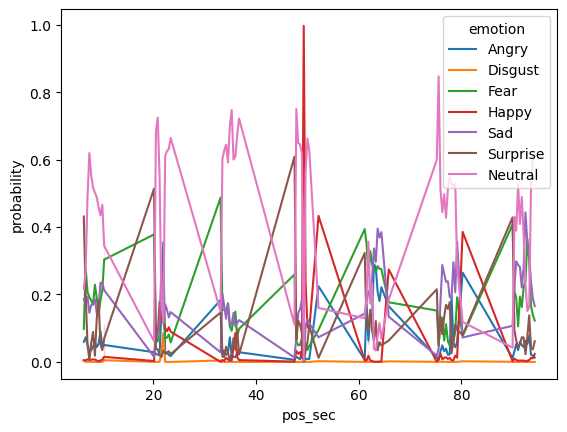

In [ ]:
sns.lineplot(data = df_plotting, x = 'pos_sec', y='probability', hue = 'emotion')

In [ ]:
fig = px.area(df_plotting, x="pos_sec", y="probability", color="emotion")
fig.show()

In [ ]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [ ]:
fig = px.area(df, x="pos_sec", y="moving_avg", color="emotion")
fig.show()

# I Adjusted plots until here

### Still Open
* Periods with no people are by now interlinked - so we have straight in the original data and valleys forming in the rolling mean.
* Tha Barcharts show quite well when multiple people com into play - but by now, their values are summed up. If we can get Character Recognition to work, that will be great - if not, at least we can try to reduce it down to one person per frame, but there's no guarantee that we always get the same person.
* With objects and classes we could structure the code even better
* I have the feeling from my videos that the performance is not super good right - maybe we achieve to get better results somehow.
* Much faster on youtube video data looking at Video_seconds analyzed per processing second.

#### After Dinner the youtube integration stopped working, I can't see why!

In [ ]:
sns.lineplot(data = df_plotting, x = 'Frame', y='moving_avg', hue = 'feeling')

ValueError: Could not interpret value `Frame` for parameter `x`

In [ ]:
df_plotting

,Frame,feeling,probability,moving_avg
0,0,Angry,0.005274,NaN
1,1,Angry,0.010392,NaN
2,2,Angry,0.008759,NaN
3,3,Angry,0.028516,NaN
4,4,Angry,0.004002,NaN
...,...,...,...,...
6197,881,Neutral,0.185039,0.202502
6198,882,Neutral,0.252427,NaN
6199,883,Neutral,0.252427,NaN
6200,884,Neutral,0.240728,NaN


In [ ]:
max_prob_rows = df_plotting.groupby('Frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()
max_prob_df


,Frame,feeling,probability,moving_avg
2658,0,Happy,0.955532,0.505082
2659,1,Happy,0.935133,0.593292
2660,2,Happy,0.923429,0.665813
2661,3,Happy,0.822713,0.738803
2662,4,Happy,0.938086,0.825939
...,...,...,...,...
3539,881,Happy,0.507732,0.446257
3540,882,Happy,0.367060,0.402680
3541,883,Happy,0.367060,0.351637
3542,884,Happy,0.399157,0.299369


In [ ]:
sns.barplot(data = max_prob_df, x = 'Frame', y='probability', hue='feeling')

NameError: name 'max_prob_df' is not defined

In [ ]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [ ]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['Frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('Frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['Frame', 'feeling'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('Frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='Frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='Frame', 
    y='probability_normalized', 
    color='feeling', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Feeling Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [ ]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [ ]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [ ]:
feeling_counts

NameError: name 'feeling_counts' is not defined

: 

In [ ]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [ ]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

In [ ]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [ ]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.